# Introduction

This notebook contains the experiments and results presented in the paper. They are organized in 3 parts:

* Predictive performance
* Uncertianty estimations
* Ablation study

In [2]:
import sys
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Add project root to the Python path
code_root = os.path.abspath("../scripts")   # notebooks/ → project root
sys.path.append(code_root)

import numpy as np
import torch
from helpers import set_seed
from utils import load_preds_labels, print_metrics, plot_vae_vs_deterministic, interval_coverage_error, plot_interval_coverage_error, regression_ece, plot_pit_cdf_histogram

# Determine device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seed for reproducibility
set_seed(42)

# Define data paths
labels_path = f'../data/labels/nsfnetbw_geant2bw.npy'
unseen_labels_path = f'../data/labels/gbnbw.npy'
deterministic_prediction_path_seen = f'../data/predictions/predictor/nsfnetbw_geant2bw_ND4_PREDM_D_EP200_H32_LR0.001_LRSplateau.npy'
vae_prediction_path_seen = f'../data/predictions/autoencoder/nsfnetbw_geant2bw_50S_MND4_CPF4VAEPNM_D_EP200_H32_L32_LR0.001_LRSplateau_B0.001_BSconstant.npy'
deterministic_prediction_path_unseen = f'../data/predictions/predictor/gbnbw_ND4_PREDM_D_EP200_H32_LR0.001_LRSplateau.npy'
vae_prediction_path_unseen = f'../data/predictions/autoencoder/gbnbw_50S_MND4_CPF4VAEPNM_D_EP200_H32_L32_LR0.001_LRSplateau_B0.001_BSconstant.npy'
dataset_split = 2000*182 # 2000 samples of 182 flows each

Using device: cuda


# Predictive performance

## Evaluation on seen and unseen topologies

### Deterministic baseline

In [2]:
# NSFNET / GEANT2BW dataset
print('Deterministic model evaluation on NSFNetBW/GEANT2BW dataset')
prediction_path = f'../data/predictions/predictor/nsfnetbw_geant2bw_ND4_PREDM_D_EP200_H32_LR0.001_LRSplateau.npy'
predictions, labels = load_preds_labels(prediction_path, labels_path)
print_metrics(predictions, labels)

# GBNBW dataset
print('\nDeterministic model evaluation on GBNBW dataset')
prediction_path = f'../data/predictions/predictor/gbnbw_ND4_PREDM_D_EP200_H32_LR0.001_LRSplateau.npy'
predictions, labels = load_preds_labels(prediction_path, unseen_labels_path)
print_metrics(predictions, labels)

Deterministic model evaluation on NSFNetBW/GEANT2BW dataset
RMSE: 0.0235
RMSPE: 3.2932%
MAE: 0.0105
MAPE: 2.2676%
R²: 0.9990
--- Metrics for labels >= 95th percentile (2.4312) and <= 99.9th percentile (5.2241) ---
RMSE: 0.0599
RMSPE: 1.8348%
MAE: 0.0412
MAPE: 1.3040%
R²: 0.9858

Deterministic model evaluation on GBNBW dataset
RMSE: 0.0522
RMSPE: 4.5365%
MAE: 0.0232
MAPE: 2.7842%
R²: 0.9983
--- Metrics for labels >= 95th percentile (3.4482) and <= 99.9th percentile (6.7315) ---
RMSE: 0.1171
RMSPE: 2.6074%
MAE: 0.0804
MAPE: 1.8220%
R²: 0.9868


### cFVAE 

In [3]:
name_extension = ''
beta = 0.001

# Load predictions and labels and plot them
print('Evaluation metrics for Autoencoder with Planar Flows on NSFNetBW/GEANT2BW dataset')
prediction_path = f'../data/predictions/autoencoder/nsfnetbw_geant2bw_50S_MND4_CPF4VAEPNM_D_EP200_H32_L32_LR0.001_LRSplateau_B0.001_BSconstant.npy'
predictions, labels = load_preds_labels(prediction_path, labels_path)
predictions_mean = np.mean(predictions, axis=1)
print(f'Number of samples: {predictions.shape[0]}')
print_metrics(predictions_mean, labels)

print('\nEvaluation metrics for Autoencoder with Planar Flows on GBNBW dataset')
prediction_path = f'../data/predictions/autoencoder/gbnbw_50S_MND4_CPF4VAEPNM_D_EP200_H32_L32_LR0.001_LRSplateau_B0.001_BSconstant.npy'
predictions, labels = load_preds_labels(prediction_path, unseen_labels_path)
predictions_mean = np.mean(predictions, axis=1)
print_metrics(predictions_mean, labels)

Evaluation metrics for Autoencoder with Planar Flows on NSFNetBW/GEANT2BW dataset
Number of samples: 1468000
RMSE: 0.0222
RMSPE: 3.5465%
MAE: 0.0098
MAPE: 2.3861%
R²: 0.9991
--- Metrics for labels >= 95th percentile (2.4312) and <= 99.9th percentile (5.2241) ---
RMSE: 0.0576
RMSPE: 1.7175%
MAE: 0.0386
MAPE: 1.2109%
R²: 0.9868

Evaluation metrics for Autoencoder with Planar Flows on GBNBW dataset
RMSE: 0.0395
RMSPE: 3.3767%
MAE: 0.0175
MAPE: 2.3480%
R²: 0.9990
--- Metrics for labels >= 95th percentile (3.4482) and <= 99.9th percentile (6.7315) ---
RMSE: 0.0943
RMSPE: 2.0089%
MAE: 0.0659
MAPE: 1.4642%
R²: 0.9915


## Evaluate performance vs Numbers of samples drawn

Plotting VAE Predictor vs Deterministic Predictor MAE on NSFNetBW/GEANT2BW and GBNBW datasets


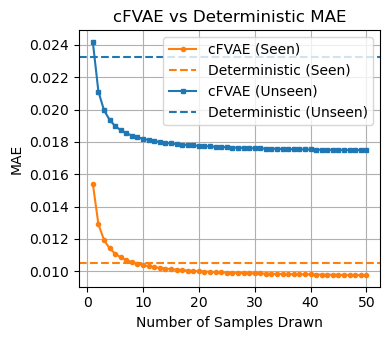

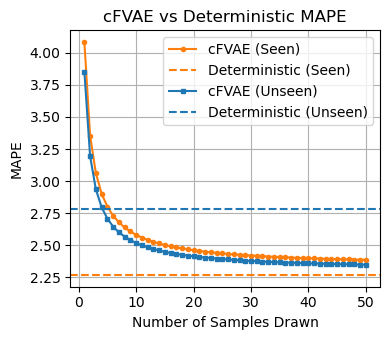

In [4]:
print('Plotting VAE Predictor vs Deterministic Predictor MAE on NSFNetBW/GEANT2BW and GBNBW datasets')
# Load deterministic predictions for seen dataset
y_pred_det_seen, targets_all_seen = load_preds_labels(deterministic_prediction_path_seen, labels_path)
# Load deterministic predictions for unseen dataset
y_pred_det_unseen, targets_all_unseen = load_preds_labels(deterministic_prediction_path_unseen, unseen_labels_path)
# Load VAE predictions for seen dataset
y_pred_vae_seen, targets_all_seen = load_preds_labels(vae_prediction_path_seen, labels_path)
# Load VAE predictions for unseen dataset
y_pred_vae_unseen, targets_all_unseen = load_preds_labels(vae_prediction_path_unseen, unseen_labels_path)
plot_vae_vs_deterministic(y_pred_vae_seen, targets_all_seen, y_pred_vae_unseen, targets_all_unseen, y_pred_det_seen, y_pred_det_unseen, metric_name='MAE')
plot_vae_vs_deterministic(y_pred_vae_seen, targets_all_seen, y_pred_vae_unseen, targets_all_unseen, y_pred_det_seen, y_pred_det_unseen, metric_name='MAPE')

# Uncertainty estimations

## Seen topologies

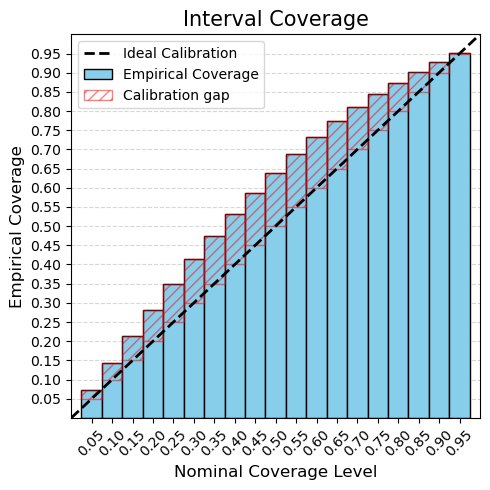

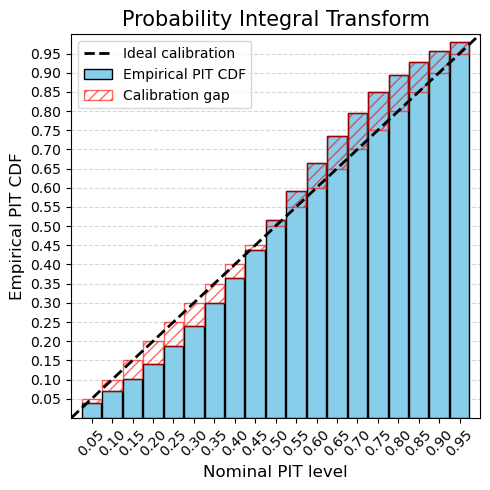

In [5]:
predictions, labels = load_preds_labels(vae_prediction_path_seen, labels_path)
    
# Compute mean and std of predictions
pred_mean = predictions.mean(axis=1)
pred_std = predictions.std(axis=1)

y_true = labels
mu = pred_mean
sigma = pred_std + 1e-6  # avoid division by zero

# Compute Interval Coverage Error (ICE)
ice_list = []
ec_list = []
alphas = np.linspace(0.05, 0.95, 19)
for alpha in alphas:
    lower_q = (1 - alpha) / 2
    upper_q = 1 - lower_q
    # Compute empirical lower and upper bounds
    y_lower = np.percentile(predictions, lower_q * 100, axis=1)
    y_upper = np.percentile(predictions, upper_q * 100, axis=1)
    ec, ice = interval_coverage_error(y_true, y_lower, y_upper, nominal=alpha)
    ice_list.append(ice)
    ec_list.append(ec)
total_ice = sum(ice_list)
plot_interval_coverage_error(ec_list, total_ice, alphas)

# Compute PIT values
n_bins = 20
ece, pits = regression_ece(y_true, mu, sigma, n_bins=n_bins)
plot_pit_cdf_histogram(pits, ece, n_bins=n_bins)

## Unseen topology

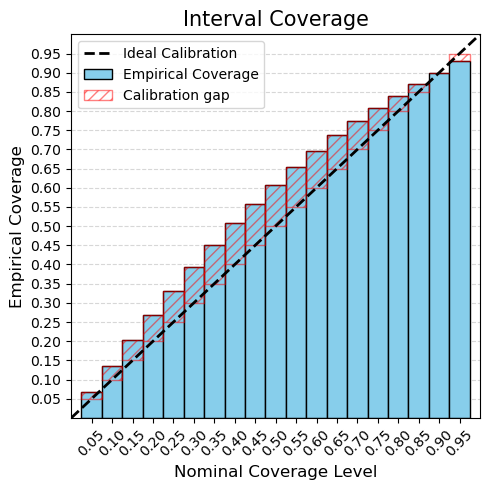

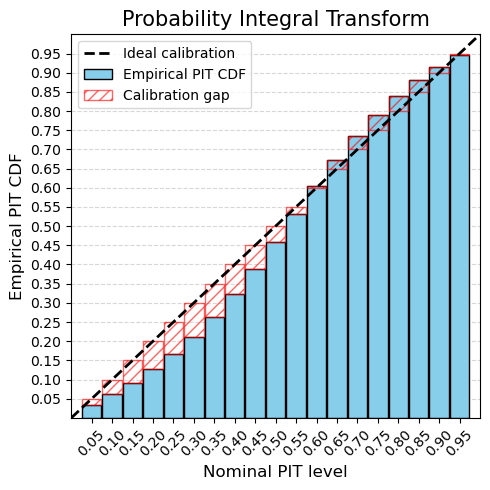

In [6]:
predictions, labels = load_preds_labels(vae_prediction_path_unseen, unseen_labels_path)
predictions = predictions[dataset_split:]
labels = labels[dataset_split:]
    
# Compute mean and std of predictions
pred_mean = predictions.mean(axis=1)
pred_std = predictions.std(axis=1)

y_true = labels
mu = pred_mean
sigma = pred_std + 1e-6  # avoid division by zero

# Compute Interval Coverage Error (ICE)
ice_list = []
ec_list = []
alphas = np.linspace(0.05, 0.95, 19)
for alpha in alphas:
    lower_q = (1 - alpha) / 2
    upper_q = 1 - lower_q
    # Compute empirical lower and upper bounds
    y_lower = np.percentile(predictions, lower_q * 100, axis=1)
    y_upper = np.percentile(predictions, upper_q * 100, axis=1)
    ec, ice = interval_coverage_error(y_true, y_lower, y_upper, nominal=alpha)
    ice_list.append(ice)
    ec_list.append(ec)
total_ice = sum(ice_list)
plot_interval_coverage_error(ec_list, total_ice, alphas)

# Compute PIT values
n_bins = 20
ece, pits = regression_ece(y_true, mu, sigma, n_bins=n_bins)
plot_pit_cdf_histogram(pits, ece, n_bins=n_bins)

## Predictive variance Seen vs Unseen

Average predicted std for dataset=nsfnetbw_geant2bw: 0.01436035055667162
Average predicted std for dataset=gbnbw: 0.02022445574402809


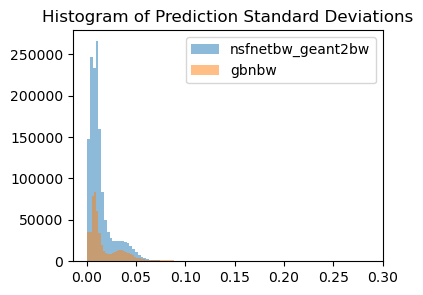

In [6]:
# Plot variance of predicitions histograms for nsfnetbw_geant2bw and gbnbw on the same plot
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 3))
for dataset in ['nsfnetbw_geant2bw', 'gbnbw']:
    prediction_path = f'../data//predictions/autoencoder/{dataset}_50S_MND4_PF4VAEPNM_D_EP200_H32_L32_LR0.001_LRSplateau_B0.001_BSconstant.npy'
    labels_path = f'../data//labels/{dataset}.npy'
    predictions, labels = load_preds_labels(prediction_path, labels_path)
    # Compute std of predictions
    pred_std = predictions.std(axis=1)
    plt.hist(pred_std, bins=100, alpha=0.5, label=dataset)
    avg_std = np.mean(pred_std)
    print(f"Average predicted std for dataset={dataset}: {avg_std}")
plt.legend()
plt.title('Histogram of Prediction Standard Deviations')
plt.show()

# Albation study

## No condition encoder

In [7]:
print('\nEvaluation metrics for Autoencoder with Planar Flows on GBNBW dataset')
prediction_path = f'../data/predictions/autoencoder/gbnbw_50S_MND4_PF4VAEPNM_D_EP200_H32_L32_LR0.001_LRSplateau_B0.001_BSconstant.npy'
predictions, labels = load_preds_labels(prediction_path, unseen_labels_path)
predictions_mean = np.mean(predictions, axis=1)
print_metrics(predictions_mean, labels)


Evaluation metrics for Autoencoder with Planar Flows on GBNBW dataset
RMSE: 0.0461
RMSPE: 3.9648%
MAE: 0.0206
MAPE: 2.5690%
R²: 0.9987
--- Metrics for labels >= 95th percentile (3.4482) and <= 99.9th percentile (6.7315) ---
RMSE: 0.1096
RMSPE: 2.4177%
MAE: 0.0812
MAPE: 1.8289%
R²: 0.9885


## No normalizing flows

In [8]:
# Load predictions and labels and plot them
prediction_path = f'../data/predictions/autoencoder/gbnbw_50S_ABL1_CVAEPNM_D_EP200_H32_L32_LR0.001_LRSplateau_B0.001_BSconstant.npy'
labels_path = f'../data//labels/gbnbw.npy'
predictions, labels = load_preds_labels(prediction_path, labels_path)
predictions_mean = np.mean(predictions, axis=1)
# Compute evaluation metrics
print_metrics(predictions_mean, labels)

RMSE: 0.0474
RMSPE: 4.3029%
MAE: 0.0205
MAPE: 2.7589%
R²: 0.9986
--- Metrics for labels >= 95th percentile (3.4482) and <= 99.9th percentile (6.7315) ---
RMSE: 0.1255
RMSPE: 2.8413%
MAE: 0.0877
MAPE: 1.9709%
R²: 0.9849
